In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

In [2]:
# Load the data
df = pd.read_csv("crop_yield2.csv")

In [3]:
# Handle Missing Data
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

In [4]:
# Remove Outliers using IQR
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [5]:
# Encode Categorical Variables
label_encoders = {}
for col in ["Crop", "Season", "State"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [6]:
# Prepare Data for Classification
X_class = df.drop(columns=["Crop", "Yield"])
y_class = df["Crop"]
scaler_class = StandardScaler()
X_class_scaled = scaler_class.fit_transform(X_class)

In [7]:
# Prepare Data for Regression
X_reg = df.drop(columns=["Yield"])
y_reg = df["Yield"]
scaler_reg = StandardScaler()
X_reg_scaled = scaler_reg.fit_transform(X_reg)

In [8]:
# Handle Class Imbalance
smote = SMOTE(random_state=42, k_neighbors=1)
X_class_resampled, y_class_resampled = smote.fit_resample(X_class_scaled, y_class)

In [9]:
# Split Data
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_class_resampled, y_class_resampled, test_size=0.2, random_state=42, stratify=y_class_resampled)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg_scaled, y_reg, test_size=0.2, random_state=42)

In [10]:
# Train Classification Model
clf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
clf.fit(Xc_train, yc_train)
yc_pred = clf.predict(Xc_test)

In [11]:
# Classification Metrics
accuracy = accuracy_score(yc_test, yc_pred)
precision = precision_score(yc_test, yc_pred, average="weighted", zero_division=1)
recall = recall_score(yc_test, yc_pred, average="weighted", zero_division=1)
f1 = f1_score(yc_test, yc_pred, average="weighted", zero_division=1)

In [12]:
# Train Regression Model
reg = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42)
reg.fit(Xr_train, yr_train)
yr_pred = reg.predict(Xr_test)

In [13]:
# Regression Metrics
mse = mean_squared_error(yr_test, yr_pred)
r2 = r2_score(yr_test, yr_pred)

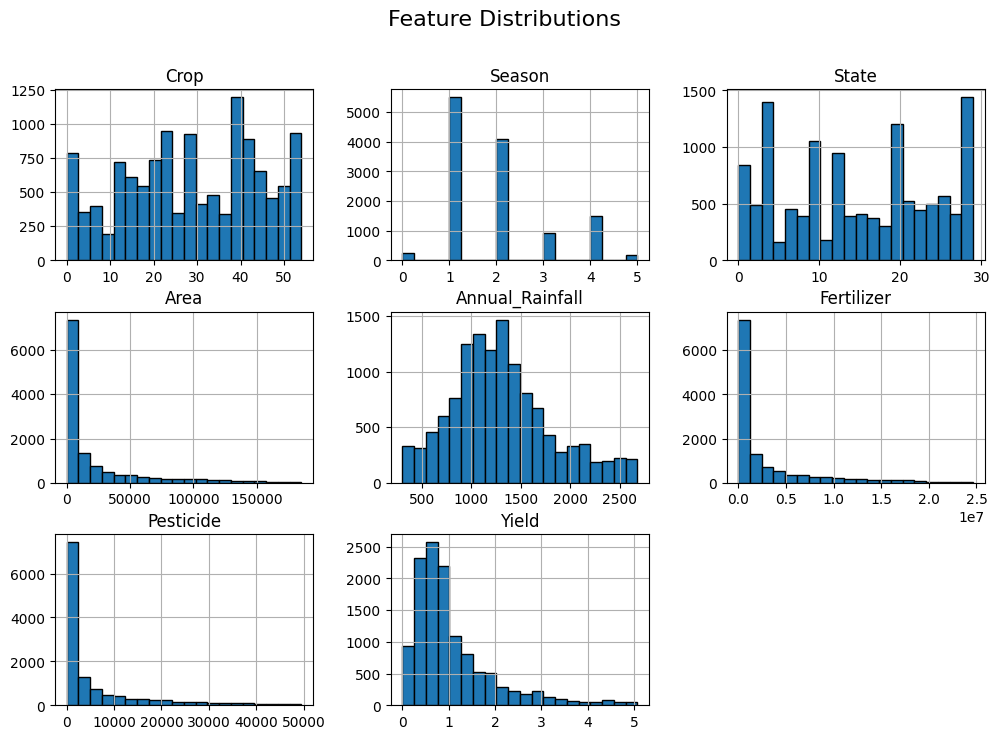

In [14]:
# Visualize Feature Distributions
df.hist(figsize=(12, 8), bins=20, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

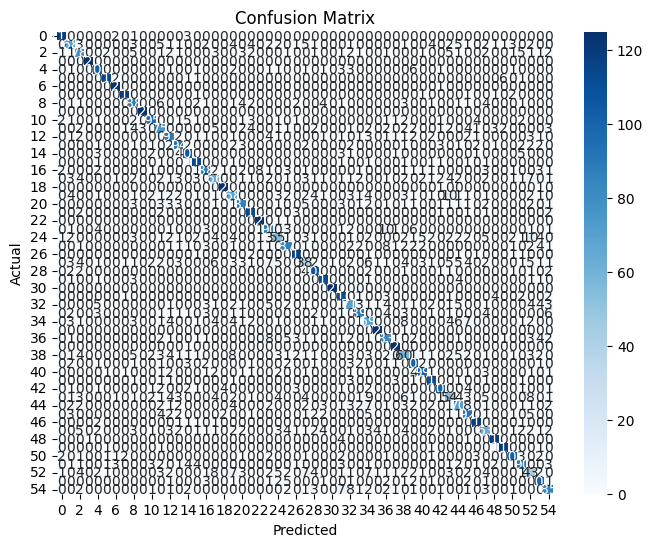

In [15]:
# Visualize Confusion Matrix
conf_matrix = confusion_matrix(yc_test, yc_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

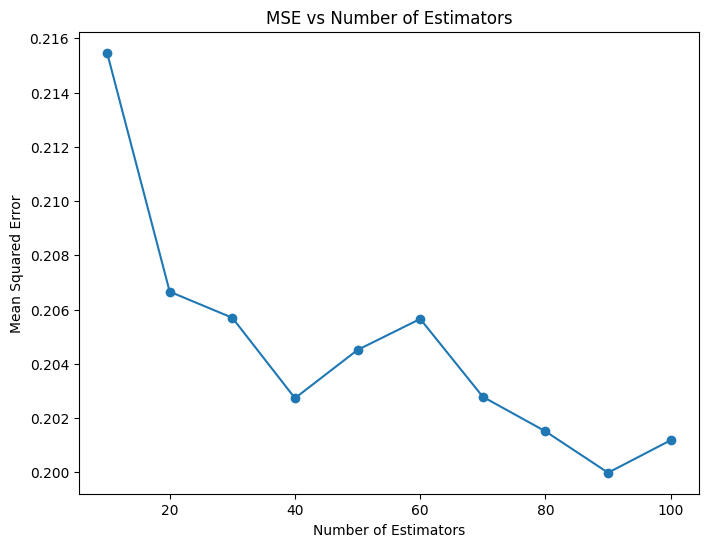

In [16]:
# Visualize MSE vs Iterations
mse_values = []
for i in range(10, 110, 10):
    temp_reg = RandomForestRegressor(n_estimators=i, max_depth=20, random_state=42)
    temp_reg.fit(Xr_train, yr_train)
    temp_pred = temp_reg.predict(Xr_test)
    mse_values.append(mean_squared_error(yr_test, temp_pred))

plt.figure(figsize=(8, 6))
plt.plot(range(10, 110, 10), mse_values, marker='o')
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Squared Error")
plt.title("MSE vs Number of Estimators")
plt.show()

In [17]:
# Output Metrics
print("\nClassification Metrics:")
print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"F1-score: {f1:.5f}")
print("\nClassification Report:")
print(classification_report(yc_test, yc_pred))

print("\nRegression Metrics:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")



Classification Metrics:
Accuracy: 0.76209
Precision: 0.75581
Recall: 0.76209
F1-score: 0.75739

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       125
           1       0.64      0.54      0.59       125
           2       0.64      0.62      0.63       125
           3       0.99      1.00      1.00       125
           4       0.77      0.82      0.79       125
           5       0.94      0.91      0.93       124
           6       0.93      0.99      0.96       125
           7       0.95      0.95      0.95       125
           8       0.67      0.70      0.69       125
           9       0.98      1.00      0.99       125
          10       0.84      0.76      0.80       125
          11       0.60      0.60      0.60       125
          12       0.67      0.73      0.70       124
          13       0.72      0.76      0.74       124
          14       0.79      0.84      0.81       125
          15   

In [ ]:
def recommend_crop_and_yield(season, state, area, rainfall, fertilizer, pesticide):
    if season not in le["Season"].classes_:
        print(f"Error: Season '{season}' not recognized. Please enter a valid season.")
        return
    if state not in le["State"].classes_:
        print(f"Error: State '{state}' not recognized. Please enter a valid state.")
        return

    season_encoded = le["Season"].transform([season])[0]
    state_encoded = le["State"].transform([state])[0]

    input_class = np.array([[season_encoded, state_encoded, area, rainfall, fertilizer, pesticide]])
    input_class_scaled = scaler_class.transform(input_class)
    predicted_crop_idx = clf.predict(input_class_scaled)[0]
    predicted_crop = label_encoders["Crop"].inverse_transform([predicted_crop_idx])[0]

    input_reg = np.array([[predicted_crop_idx, season_encoded, state_encoded, area, rainfall, fertilizer, pesticide]])
    input_reg_scaled = scaler_reg.transform(input_reg)
    predicted_yield = reg.predict(input_reg_scaled)[0]

    print("Recommended Crop:", predicted_crop)
    print("Predicted Yield:", round(predicted_yield, 2), "kg/ha")

# Example Usage
recommend_crop_and_yield(season="Kharif", state="Maharashtra", area=5000, rainfall=1500, fertilizer=200000, pesticide=5000)

NameError: name 'le' is not defined

In [5]:
def recommend_crop_and_yield(season, state, area, rainfall, fertilizer, pesticide):
    season_encoded = label_encoders["Season"].transform([season])[0] if season in label_encoders["Season"].classes_ else -1
    state_encoded = label_encoders["State"].transform([state])[0] if state in label_encoders["State"].classes_ else -1

    input_class = np.array([[season_encoded, state_encoded, area, rainfall, fertilizer, pesticide]])
    input_class_scaled = scaler_class.transform(input_class)
    predicted_crop_idx = clf.predict(input_class_scaled)[0]
    predicted_crop = label_encoders["Crop"].inverse_transform([predicted_crop_idx])[0]
    
    input_reg = np.array([[predicted_crop_idx, season_encoded, state_encoded, area, rainfall, fertilizer, pesticide]])
    input_reg_scaled = scaler_reg.transform(input_reg)
    predicted_yield = reg.predict(input_reg_scaled)[0]
    
    print("\nRecommended Crop:", predicted_crop)
    print("Predicted Yield:", round(predicted_yield, 2), "kg/ha")

# Example Usage
recommend_crop_and_yield(season="Kharif", state="Maharashtra", area=5000, rainfall=1500, fertilizer=200000, pesticide=5000)

NameError: name 'label_encoders' is not defined